1. Recebe a planilha.

2. Calcula a Porcentagem_Euploidia_Estimada com base nas faixas clínicas e pesos derivados do TCC. (Essa é a “verdade clínica”.)

3. Treina uma Rede Neural de Regressão (MLPRegressor) para prever essa porcentagem.

4. Avalia com métricas de regressão: MAE, RMSE, R².

5. Salva a planilha com a Porcentagem Estimada (verdade) e a Porcentagem Preditiva da IA.


=== MÉTRICAS DE DESEMPENHO DA REGRESSÃO ===
MAE: 17.12
RMSE: 23.84
R²: -3.053


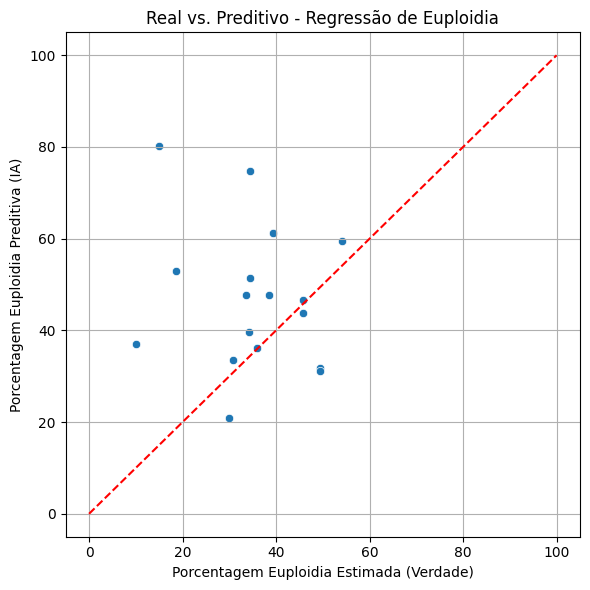


✅ Planilha salva como: Planilha_Com_Porcentagem_Regressao.xlsx


In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Carrega os dados ===
df = pd.read_excel("PlanilhaNumerica.xlsx")

# === 2. Calcula a Porcentagem de Euploidia Estimada (verdade clínica) ===
def in_range(valor, minimo, maximo):
    return 1.0 if minimo <= valor <= maximo else 0.0

def calcular_porcentagem(row):
    score = 0.0
    pesos = {
        'Idade': 28.25,
        't5': 13.56,
        'tB_tSB': 15.82,
        'cc3': 15.82,
        'Estágio': 10.00,
        'KIDScore': 10.00,
        'Morfo': 10.00,
        's2': 5.00,
        'cc2': 5.00,
        't5_t2': 5.00
    }

    score += pesos['Idade'] if row['Idade'] < 30 else (0 if row['Idade'] > 37 else pesos['Idade'] * 0.5)
    score += pesos['t5'] if in_range(row['t5'], 48.8, 56.6) else 0
    score += pesos['tB_tSB'] if row['tB-tSB'] < 5 else 0
    score += pesos['cc3'] if in_range(row['cc3 (t5-t3)'], 11, 14) else 0
    score += pesos['Estágio'] if row['Estágio'] == 5 else 0
    score += pesos['KIDScore'] if row['Kidscore'] >= 8 else 0
    score += pesos['Morfo'] if row['Morfo'] in [4, 5] else 0
    score += pesos['s2'] if in_range(row['s2 (t4-t3)'], 0.75, 5) else 0
    score += pesos['cc2'] if in_range(row['cc2 (t3-t2)'], 7.5, 11.9) else 0
    score += pesos['t5_t2'] if in_range(row['t5-t2'], 21, 32) else 0

    return round(score, 2)

df["Porcentagem_Euploidia_Estimada"] = df.apply(calcular_porcentagem, axis=1)

# === 3. Prepara os dados para regressão ===
X = df.drop(columns=["Ploidia", "Porcentagem_Euploidia_Estimada"], errors="ignore")
y = df["Porcentagem_Euploidia_Estimada"]

# Preenche colunas faltantes
colunas_validas = X.columns
for col in colunas_validas:
    X[col] = X[col].fillna(0)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalonamento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 4. Cria e treina a Rede Neural de Regressão ===
modelo = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

modelo.fit(X_train_scaled, y_train)

# === 5. Faz predições ===
y_pred = modelo.predict(X_test_scaled)

# === 6. Avalia com métricas ===
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n=== MÉTRICAS DE DESEMPENHO DA REGRESSÃO ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# === 7. Plot Gráfico Real vs. Preditivo ===
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 100], [0, 100], linestyle='--', color='red')
plt.xlabel("Porcentagem Euploidia Estimada (Verdade)")
plt.ylabel("Porcentagem Euploidia Preditiva (IA)")
plt.title("Real vs. Preditivo - Regressão de Euploidia")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Aplica no conjunto inteiro para salvar ===
X_scaled_total = scaler.transform(X)
df["Porcentagem_Euploidia_Preditiva"] = modelo.predict(X_scaled_total).round(2)

# === 9. Salva a planilha ===
df.to_excel("Planilha_Com_Porcentagem_Regressao.xlsx", index=False)

print("\n✅ Planilha salva como: Planilha_Com_Porcentagem_Regressao.xlsx")


=== MÉTRICAS DESEMPENHO DA REGRESSÃO (GradientBoosting) ===
MAE: 6.51
RMSE: 8.22
R²: 0.459


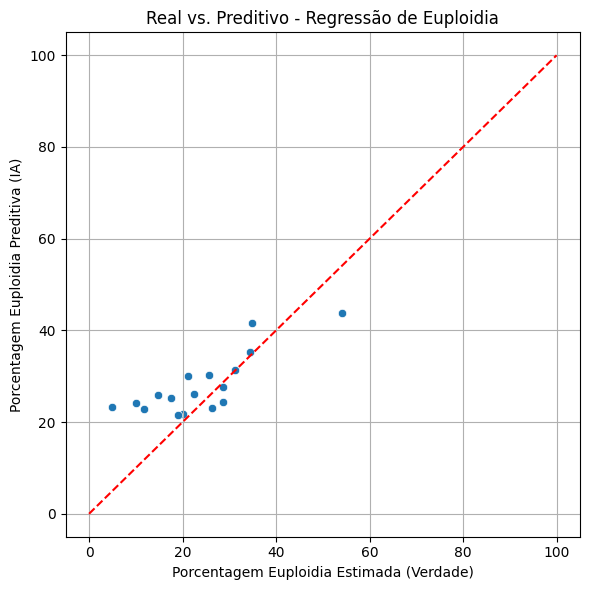


✅ Planilha salva como: Planilha_Com_Porcentagem_Regressao_GradientBoosting.xlsx


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Função faixa suave ===
def faixa_suave(valor, minimo, maximo):
    if pd.isna(valor):
        return 0.0
    centro = (minimo + maximo) / 2
    distancia = abs(valor - centro)
    max_distancia = (maximo - minimo) / 2
    score = max(0, 1 - (distancia / max_distancia))
    return score

# === 1. Carrega os dados ===
df = pd.read_excel("PlanilhaNumerica.xlsx")

# === 2. Calcula Porcentagem_Euploidia_Estimada usando faixa suave ===
def calcular_porcentagem_suave(row):
    pesos = {
        'Idade': 28.25,
        't5': 13.56,
        'tB_tSB': 15.82,
        'cc3': 15.82,
        'Estágio': 10.00,
        'KIDScore': 10.00,
        'Morfo': 10.00,
        's2': 5.00,
        'cc2': 5.00,
        't5_t2': 5.00
    }
    score = 0.0
    
    # Idade: escala suave entre <30 (1) e >37 (0), linear entre 30 e 37
    if pd.isna(row['Idade']):
        score_idade = 0
    elif row['Idade'] < 30:
        score_idade = 1.0
    elif row['Idade'] > 37:
        score_idade = 0.0
    else:
        score_idade = 1 - (row['Idade'] - 30) / (37 - 30)
    score += pesos['Idade'] * score_idade
    
    # Faixas suaves para os outros contínuos
    score += pesos['t5'] * faixa_suave(row['t5'], 48.8, 56.6)
    score += pesos['tB_tSB'] * (1.0 if row['tB-tSB'] < 5 else 0.0)  # Não tem faixa suave, é limite rígido
    score += pesos['cc3'] * faixa_suave(row['cc3 (t5-t3)'], 11, 14)
    score += pesos['Estágio'] * (1.0 if row['Estágio'] == 5 else 0.0)
    score += pesos['KIDScore'] * (1.0 if row['Kidscore'] >= 8 else 0.0)
    score += pesos['Morfo'] * (1.0 if row['Morfo'] in [4, 5] else 0.0)
    score += pesos['s2'] * faixa_suave(row['s2 (t4-t3)'], 0.75, 5)
    score += pesos['cc2'] * faixa_suave(row['cc2 (t3-t2)'], 7.5, 11.9)
    score += pesos['t5_t2'] * faixa_suave(row['t5-t2'], 21, 32)
    
    return round(score, 2)

df["Porcentagem_Euploidia_Estimada"] = df.apply(calcular_porcentagem_suave, axis=1)

# === 3. Prepara os dados para regressão ===
X = df.drop(columns=["Ploidia", "Porcentagem_Euploidia_Estimada"], errors="ignore")
y = df["Porcentagem_Euploidia_Estimada"]

# Preenche colunas faltantes com zero (pode ajustar depois se quiser)
for col in X.columns:
    X[col] = X[col].fillna(0)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalonamento (GradientBoosting não precisa obrigatoriamente, mas mantemos para manter padrão)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 4. Cria e treina o GradientBoostingRegressor ===
from sklearn.ensemble import GradientBoostingRegressor

modelo = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

modelo.fit(X_train_scaled, y_train)

# === 5. Faz predições ===
y_pred = modelo.predict(X_test_scaled)

# === 6. Avalia com métricas ===
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n=== MÉTRICAS DESEMPENHO DA REGRESSÃO (GradientBoosting) ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# === 7. Plot Gráfico Real vs. Preditivo ===
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 100], [0, 100], linestyle='--', color='red')
plt.xlabel("Porcentagem Euploidia Estimada (Verdade)")
plt.ylabel("Porcentagem Euploidia Preditiva (IA)")
plt.title("Real vs. Preditivo - Regressão de Euploidia")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Aplica no conjunto inteiro para salvar ===
X_scaled_total = scaler.transform(X)
df["Porcentagem_Euploidia_Preditiva"] = modelo.predict(X_scaled_total).round(2)

# === 9. Salva planilha com resultados ===
df.to_excel("Planilha_Com_Porcentagem_Regressao_GradientBoosting.xlsx", index=False)
print("\n✅ Planilha salva como: Planilha_Com_Porcentagem_Regressao_GradientBoosting.xlsx")


* Carregar a planilha.

* Calcular a porcentagem estimada com faixa suave (como antes).

* Rodar a regressão com GradientBoosting para a porcentagem preditiva.

* Rodar o modelo de classificação MLP para prever se é euploide (1) ou aneuploide (0).

* Salvar planilha com as colunas: porcentagem estimada, porcentagem preditiva, e classificação predita.

MAE: 6.51, RMSE: 8.22, R2: 0.459
✅ Planilha salva como Planilha_Final_Com_Regressao_Classe.xlsx
✅ Planilha salva como Planilha_Somente_Euplides.xlsx


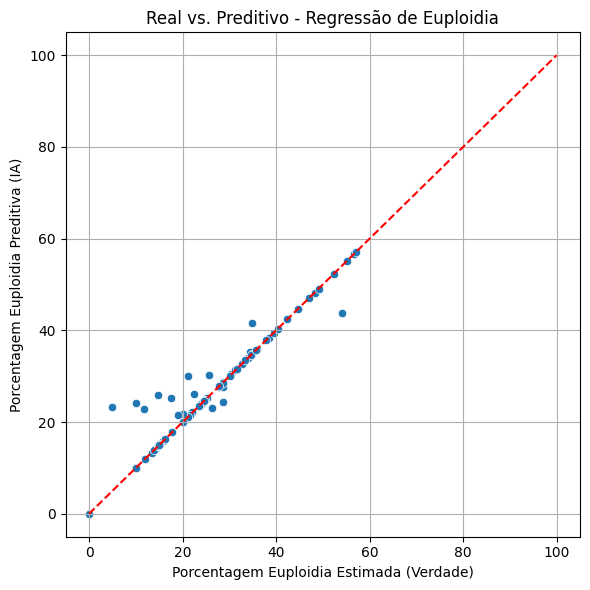

In [6]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Função faixa suave ===
def faixa_suave(valor, minimo, maximo):
    if pd.isna(valor):
        return 0.0
    centro = (minimo + maximo) / 2
    distancia = abs(valor - centro)
    max_distancia = (maximo - minimo) / 2
    score = max(0, 1 - (distancia / max_distancia))
    return score

# === 1. Carrega os dados ===
df = pd.read_excel("PlanilhaNumerica.xlsx")

# === 2. Calcula Porcentagem_Euploidia_Estimada usando faixa suave ===
def calcular_porcentagem_suave(row):
    pesos = {
        'Idade': 28.25,
        't5': 13.56,
        'tB_tSB': 15.82,
        'cc3': 15.82,
        'Estágio': 10.00,
        'KIDScore': 10.00,
        'Morfo': 10.00,
        's2': 5.00,
        'cc2': 5.00,
        't5_t2': 5.00
    }
    score = 0.0
    
    # Idade: escala suave entre <30 (1) e >37 (0), linear entre 30 e 37
    if pd.isna(row['Idade']):
        score_idade = 0
    elif row['Idade'] < 30:
        score_idade = 1.0
    elif row['Idade'] > 37:
        score_idade = 0.0
    else:
        score_idade = 1 - (row['Idade'] - 30) / (37 - 30)
    score += pesos['Idade'] * score_idade
    
    # Faixas suaves para os outros contínuos
    score += pesos['t5'] * faixa_suave(row['t5'], 48.8, 56.6)
    score += pesos['tB_tSB'] * (1.0 if row['tB-tSB'] < 5 else 0.0)  # limite rígido
    score += pesos['cc3'] * faixa_suave(row['cc3 (t5-t3)'], 11, 14)
    score += pesos['Estágio'] * (1.0 if row['Estágio'] == 5 else 0.0)
    score += pesos['KIDScore'] * (1.0 if row['Kidscore'] >= 8 else 0.0)
    score += pesos['Morfo'] * (1.0 if row['Morfo'] in [4, 5] else 0.0)
    score += pesos['s2'] * faixa_suave(row['s2 (t4-t3)'], 0.75, 5)
    score += pesos['cc2'] * faixa_suave(row['cc2 (t3-t2)'], 7.5, 11.9)
    score += pesos['t5_t2'] * faixa_suave(row['t5-t2'], 21, 32)
    
    return round(score, 2)

df["Porcentagem_Euploidia_Estimada"] = df.apply(calcular_porcentagem_suave, axis=1)

# === 3. Prepara dados para regressão ===
X = df.drop(columns=["Ploidia", "Porcentagem_Euploidia_Estimada"], errors="ignore")
y = df["Porcentagem_Euploidia_Estimada"]

for col in X.columns:
    X[col] = X[col].fillna(0)

# Split treino/teste só se quiser treinar, aqui vamos treinar para gerar modelo (pode ser comentado para só usar modelo salvo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalonamento
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

# === 4. Treina o GradientBoostingRegressor ===
modelo_reg = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
modelo_reg.fit(X_train_scaled, y_train)

# === 5. Avaliação regressão (opcional) ===
y_pred = modelo_reg.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")

# === 6. Aplica no dataset inteiro ===
X_scaled_total = scaler_reg.transform(X)
df["Porcentagem_Euploidia_Preditiva"] = modelo_reg.predict(X_scaled_total).round(2)

# === 7. Carrega modelo de classificação e scaler ===
modelo_clf = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler_clf = joblib.load("scaler_mlp_20250610_113659.pkl")

# Prepara dados para classificação (usando as features esperadas pelo scaler_clf)
X_clf = df.copy()
for col in scaler_clf.feature_names_in_:
    if col not in X_clf.columns:
        X_clf[col] = 0

X_clf = X_clf[scaler_clf.feature_names_in_]
X_clf_scaled = scaler_clf.transform(X_clf)

# Faz predição da classe euploide (1) ou não (0)
classes_preditas = modelo_clf.predict(X_clf_scaled)
df["Classe_Prevista"] = classes_preditas.astype(int)

# === 8. Salva planilha final com tudo ===
df.to_excel("Planilha_Final_Com_Regressao_Classe.xlsx", index=False)
print("✅ Planilha salva como Planilha_Final_Com_Regressao_Classe.xlsx")

# === 9. Opcional: salva só os euploides ===
df_euploides = df[df["Classe_Prevista"] == 1]
df_euploides.to_excel("Planilha_Somente_Euplides.xlsx", index=False)
print("✅ Planilha salva como Planilha_Somente_Euplides.xlsx")

# === 10. Plota gráfico regressão final ===
plt.figure(figsize=(6,6))
sns.scatterplot(x=df["Porcentagem_Euploidia_Estimada"], y=df["Porcentagem_Euploidia_Preditiva"])
plt.plot([0,100],[0,100], 'r--')
plt.xlabel("Porcentagem Euploidia Estimada (Verdade)")
plt.ylabel("Porcentagem Euploidia Preditiva (IA)")
plt.title("Real vs. Preditivo - Regressão de Euploidia")
plt.grid(True)
plt.tight_layout()
plt.show()